<a href="https://colab.research.google.com/github/ryota1431/google_colab/blob/main/uv_pl_kaleida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pythonを用いたグラフを重ねる操作の自動化【Kaleida Graph】

滴定試験等で複数のデータをプロットするためのqdaファイルを作成します。

### 滴定試験のファイルの命名規則について
以下の命名規則に従ってファイル名を付けてください。
- UVの場合
```
yyyymmdd_host_gest_eq_solvent_nuL.txt
```
- PLの場合
```
yyyymmdd_host_gest_eq_solvent_wavelength_nuL.txt
```

| 項目         | 説明                                           |
|--------------|------------------------------------------------|
| yyyymmdd     | 20241121のような形式の日付                     |
| host | ホスト分子                                       |
| gest         | ゲスト分子                                     |
| solvent      | 溶媒                                           |
| wavelength   | 励起波長 "300nm","400nm"のように単位をつける   |
| nuL          | 滴下したゲストの量 "0uL","2uL"のように単位をつける (uL以外はつけないでください) |

---

## Step 1: 必要なライブラリのインストールとインポート

In [ ]:
! pip install qdafile
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import os
from qdafile import QDAfile

## Step2: 必要な関数の定義

In [ ]:
import os
from qdafile import QDAfile

# ディレクトリにあるtxtファイルの名前のリストを取得する関数
def get_txt_list(directory):
    txt_list = []
    for file in os.listdir(directory):
        if file.endswith('.txt'):
            txt_list.append(file)
    return txt_list

#txtファイルの名前のリストをソートする関数
#filenameの形式　yyyymmdd_host_gest_eq_solvent_nuL.txt
#yyyymmddは日付、hostはホスト分子、gestはゲスト分子、eqは100uLのゲスト分子を滴下した時の当量、solventは溶媒、nuLは滴下したイオンの量
#滴下したイオンの量でソートする
def sort_txt_list(txt_list):
    def extract_number(filename):
        # ファイル名の最後の部分を取得し、'uL'または'μL'を削除して数値に変換
        try:
            return int(filename.split('_')[-1].replace('μL', '').split('.')[0])
        except ValueError:
            pass
        try:
            return int(filename.split('_')[-1].replace('uL', '').split('.')[0])
        except ValueError:
            return float('inf')  # 数値が見つからない場合は無限大を返す

    txt_list.sort(key=extract_number)
    nuL_list = []
    for txt in txt_list:
        # ファイル名の最後の部分を取得し、'uL'または'μL'を削除して数値に変換
        nuL_list.append(txt.split('_')[-1].replace('u', '').replace('µ', '').replace('L', '').split('.')[0])

    for i in range(len(nuL_list)):
        nuL_list[i] = int(nuL_list[i])

    return txt_list, nuL_list

# tab区切りのtxtファイルを読み込む関数
def read_txt(file_path):
    with open(file_path, 'r', encoding='shift_jis') as file:
        data = file.readlines()

    # 空行や変換できない文字列をスキップ
    processed_data = {}
    for line in data:
        try:
            processed_line = [float(x) for x in line.split()]
            if len(processed_line) >= 2:
                processed_data[processed_line[0]] = processed_line[1]
        except ValueError:
            continue

    return processed_data

# ディレクトリにあるtxtファイルを読み込んで、辞書に格納する関数
# 辞書のキーは波長、値は吸光度または蛍光強度
def read_txts(directory):
    txt_list = get_txt_list(directory)
    txt_list, nuL_list = sort_txt_list(txt_list)
    list_of_data = []
    for txt in txt_list:
        list_of_data.append(read_txt(os.path.join(directory, txt)))
    return list_of_data, nuL_list

# qdaを作成する関数
# dataには2次元リストを格納する。
# data = [[wavelength1, wavelength2, ...], [absorbance1-1, absorbance1-2, ...], [absorbance2-1, absorbance2-2, ...], ...]
def create_qda_file(directory, output_file):
    # 全ての波長を取得
    list_of_data, nuL_list = read_txts(directory)
    all_wavelengths = sorted(set().union(*[data.keys() for data in list_of_data]))

    # 吸光度データを並べる
    qda_data = []
    qda_data.append(all_wavelengths)
    for data in list_of_data:
        qda_data.append([data.get(wavelength, 0) for wavelength in all_wavelengths])

    # QDAファイルに書き込む
    headers = ['Wavelength']
    for nuL in nuL_list:
        headers.append(f'{nuL}uL')
    #
    dtypes = ['>f8'] * len(headers)

    qda = QDAfile(qda_data, headers=headers, dtypes=dtypes)
    qda.write(f"/content/drive/MyDrive/uvpldata/qda/{output_file}")

## Step3: データファイルのインポート
---
google colablatryに対して自分のgoogle driveのマウントを行います。

google driveに事前にデータを格納する必要があるため、下記の指示にしたがってフォルダを作成してください。
google driveのMyDrive直下にuvpldataというフォルダを作成して、そのフォルダの直下にdata,qda,svgという名前のフォルダを作成してください。
```
MyDrive/
└── uvpldata/
    ├── data/   ← 滴定データ（txtファイル）を入れる
    ├── qda/    ← QDAファイルを保存する場所
    └── svg/    ← グラフ（SVG形式）を保存する場所

```
滴定データをまとめたフォルダの末尾にはUVまたはPLの文字をアンダーバー区切りでつけるようにしてください。
```
 MyDrive/uvpldata/data/20240517_sample1_UV/
├── 20240517_reactant1_ion1_10eq_solvent1_0uL.txt
├── 20240517_reactant1_ion1_10eq_solvent1_2uL.txt
├── ...
```

In [ ]:
# Googleドライブにマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  ## Step4: データプレビュー用の関数定義
  ---
  上記コードではQDAfileを生成するだけでgoogle clab上ではグラフの確認ができない。おまけでプレビュー機能の関数定義を行う。

In [ ]:
def plot_spectra(directory, title, y_label, xlim_range, output_dir):
    # データと滴下量を読み込み
    list_of_data, nuL_list = read_txts(directory)

    plt.figure(figsize=(6, 4))
    plt.rcParams['font.size'] = 8
    # plt.rcParams['font.family']= 'sans-serif'
    # plt.rcParams['font.sans-serif'] = ['Arial']


    for data, nuL in zip(list_of_data, nuL_list):
        wavelengths = sorted(data.keys())
        values = [data[wl] for wl in wavelengths]

        if nuL == 0:
            color = 'red'
            line = 2
            label = f'{nuL} uL'
        elif nuL == max(nuL_list):
            color = 'blue'
            line = 2
            label = f'{nuL} uL'
        else:
            color = 'black'
            line = 1.0
            label = ''

        plt.plot(
            wavelengths, values,
            color=color,
            linestyle='-',
            linewidth=line,
            marker='o',
            markersize=0,
            markerfacecolor='white',
            markeredgewidth=1.5,
            label=label
        )

    plt.xlabel('Wavelength (nm)', fontsize=14, fontweight='bold', color='k')
    plt.xlim(*xlim_range)
    plt.ylim(0,)
    plt.ylabel(y_label, fontsize=14, fontweight='bold', color='k')
    # plt.title(title)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend(title='Drop volume', loc='upper right', bbox_to_anchor=(1, 1))
    plt.grid(False)
    plt.tight_layout()
    plt.tick_params(axis='both', direction='in')
    plt.savefig(f'{output_dir}/{title}.svg', format='svg', bbox_inches='tight')
    plt.show()

## Step5: QDAfileの生成とプレビュー

['S30_18Azcr-B_KPF6_UV', 'S26_15Azcr-B_TBAF_UV', 'S27_15Azcr-B_TBAF_PL', 'S27_18Azcr-B_TBAF_PL']
S30_18Azcr-B_KPF6_UV


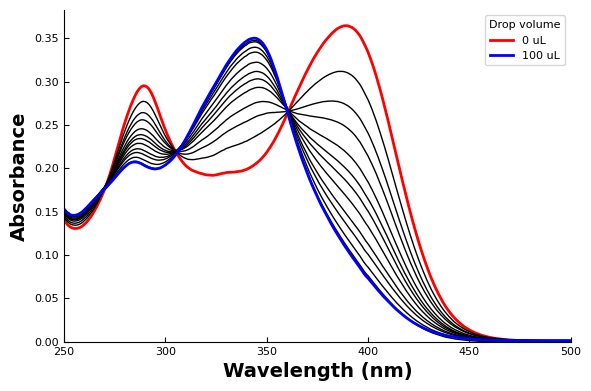

S26_15Azcr-B_TBAF_UV


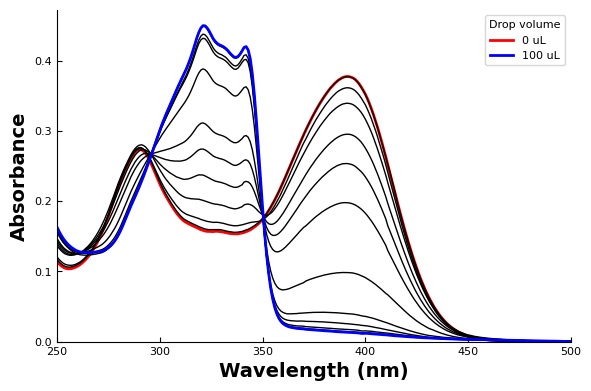

S27_15Azcr-B_TBAF_PL


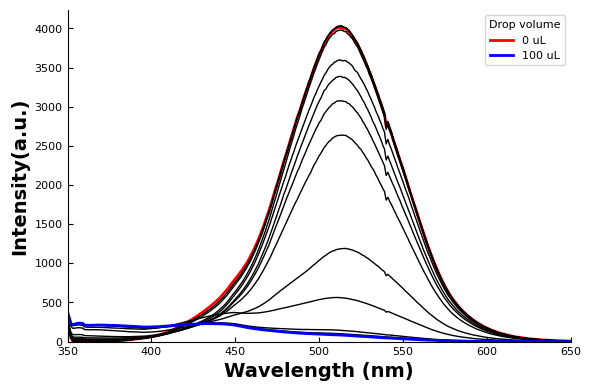

S27_18Azcr-B_TBAF_PL


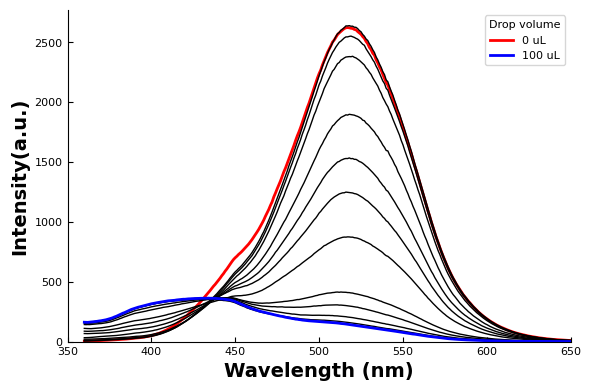

In [ ]:
folder_list = os.listdir('/content/drive/MyDrive/uvpldata/data')
print(folder_list)

# dataフォルダ内の各フォルダに対してqdaファイルを作成する
for folder in folder_list:
    directory = os.path.join('/content/drive/MyDrive/uvpldata/data', folder)
    if os.path.isdir(directory):
        print(f"{folder}")
        create_qda_file(f'{directory}', f'{folder}.qda')
        if folder.split("_")[-1] == "UV":
            plot_spectra(directory, folder, y_label='Absorbance', xlim_range=(250, 500), output_dir='/content/drive/MyDrive/uvpldata/svg')
        if folder.split("_")[-1] == "PL":
            plot_spectra(directory, folder, y_label='Intensity(a.u.)', xlim_range=(350, 650), output_dir='/content/drive/MyDrive/uvpldata/svg')
    else:
        print(f"Skipping non-directory: {directory}")